In [1]:
import json, os
from functional import seq,pseq
from fn import _
import requests as r
from typing import Set, Tuple, List

In [47]:
#optional
#print(r.delete("http://localhost:9200/law_index6").json())

In [11]:
create_index_body = {
  "settings": {
    "analysis": {
      "analyzer": {
        "my_custom_analyzer": {
          "type": "custom",
          "tokenizer": "standard",
          "filter": [
            "law_synonyms",
            "morfologik_stem",
            "lowercase"
          ]
        }
      },
      "filter": {
        "law_synonyms": {
          "type": "synonym",
          "synonyms": [
            "kpc  => kodeks postępowania cywilnego",
            "kpk => kodeks postępowania karnego",
            "kk => kodeks karny",
            "kc => kodeks cywilny"
            ]
        }
      }
    }
  },
  "mappings": {
    "_doc": {
      "properties": {
        "title": {
          "type": "text",
          "analyzer": "default",
          "search_analyzer": "default",
          "search_quote_analyzer": "default"
        },
        "content": {
          "type": "text",
          "term_vector": "with_positions_offsets_payloads",
          "analyzer": "my_custom_analyzer",
          "search_analyzer": "my_custom_analyzer",
          "search_quote_analyzer": "my_custom_analyzer"
        }
      }
    }
  }
}


create_resp = r.put("http://localhost:9200/law_index6",json=create_index_body)
print(create_resp.json())


{'acknowledged': True, 'shards_acknowledged': True, 'index': 'law_index6'}


In [12]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import os
es = Elasticsearch(retry_on_timeout=True)

actions = [{
    "_index": "law_index6",
    "_id": i,
    "_type": "_doc",
    "_source": {
        "content": open("../ustawy/" + file).read(),
        "filename": file
    }
} for i, file in enumerate(os.listdir("../ustawy"))]

helpers.bulk(es, actions)

(1180, [])

In [3]:
def get_termvectors(doc_id):
    data = {                                                                                      
      "fields" : ["content"],                                                                                                         
      "offsets" : True,                                                                                         
      "positions" : True,                                                                                                                                                                                                                                                          
      "term_statistics" : True,                                       
      "field_statistics" : True                                                                                                                                                                                                                                                    
    }   
    url = "http://localhost:9200/law_index6/_doc/{}/_termvectors".format(doc_id)
    response = r.post(url,json=data)
    return json.loads(response.content)


In [4]:
def frequency_extractor(term_dict):
    return term_dict['term_freq']

def body_to_freqs(body): #Sequence[str,int]
    return seq(body['term_vectors']['content']['terms'].items())\
        .filter(lambda x: x[0].isalpha())\
        .map(lambda x: (x[0],frequency_extractor(x[1])))

In [5]:
def get_freqs(doc_id): #Sequence[Term,Ocurrences]
    body = get_termvectors(doc_id)
    return body_to_freqs(body)

# Get docs from index 

In [49]:
def get_ids():
    match_all_query = {
      "query": {
        "match_all": {}
      },
        "size":1200,
      "_source": "_id"
    }

    resp = r.post("http://localhost:9200/law_index6/_search",json=match_all_query)
    hits = resp.json()['hits']['hits']
    return seq(hits).map(lambda x: x['_id'])

In [50]:
frequency_list = get_ids()\
.flat_map(lambda ajdi: get_freqs(ajdi))\
.group_by(lambda x:x[0])\
.map(lambda group: (
    group[0],
    seq(group[1]).map(lambda x:x[1]).sum()
))\
.filter(lambda x:x[0].isalpha() and len(x[0])>=2)\
.order_by(lambda x: -x[1])
# frequency_list.to_csv("frequency_list.out")
frequency_list = seq.csv("frequency_list.out").map(lambda x: (x[0],int(x[1])))

In [51]:
frequency_list

wiek,188681
ojciec,65253
ocean,65202
do,61002
artykuł,53912
usta,53705
na,50809
który,49562
on,49331
się,46522


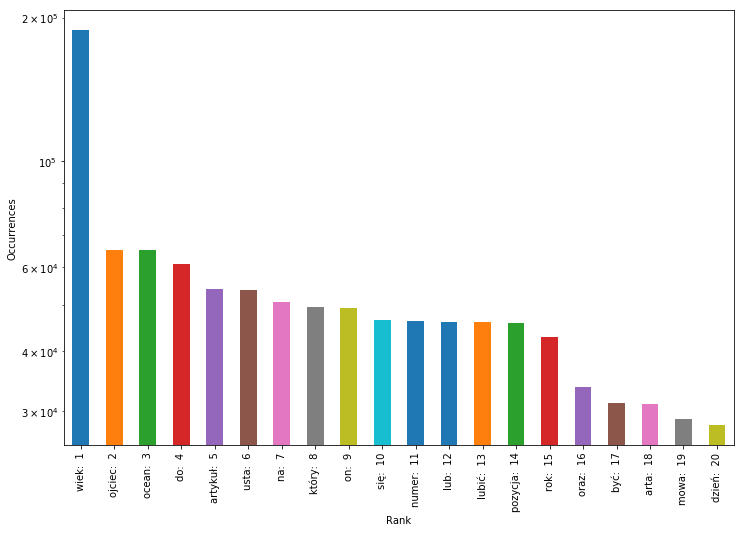

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plot_data = frequency_list.take(20)
freq_series = pd.Series(plot_data.map(lambda x:x[1]).to_list())

x_labels = plot_data.map(lambda x:x[0]).enumerate().map(lambda enum: enum[1] +":  "+ str(enum[0]+1)).to_list()

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
# ax.set_title('Rank')
ax.set_xlabel('Rank')
ax.set_ylabel('Occurrences')
ax.set_yscale('log')
ax.set_xticklabels(x_labels)

rects = ax.patches

# Using polimorfologik 
> First i had to create wordlist from dictionary:
``` bash
cat polimorfologik-2.1.txt| gawk -F";" '{print tolower($1)"\n"tolower($2)}' | grep -v "-" | uniq > ../polibash.out
```
> `gawk` is GNU awk (linuxy version of awk that supports utf-8 in tolower) on linux use `awk`


In [4]:
polish_dict = set(map(lambda x: x[:-1] ,open("polibash.out").readlines()))

### Top 30 words not in dict:

In [5]:
top30_non_in_dict = frequency_list.filter(lambda x: x[0] not in polish_dict).take(30)

In [5]:
from functional.streams import Sequence

def display_seq(sequence:Sequence,rows:int)-> None:
        sequence._repr_html_= lambda :sequence.tabulate(rows,tablefmt='html')
        display(sequence)
        sequence._repr_html_= lambda :sequence.tabulate(10,tablefmt='html')

In [9]:
display_seq(top30_non_in_dict,30)

margin,1111
późn,1080
family,543
text,531
mso,448
bottom,399
face,327
panose,326
serif,325
gmo,298
times,296


> English words appeared here from `2003_1187.txt`. This file contains some CSS- like thing.

### Words with lte 3 occurrences :

In [6]:
words_with_lt3_occurrences= frequency_list.filter(lambda x: x[1] <=3 and x[0] not in polish_dict)

In [7]:
display_seq(words_with_lt3_occurrences,50)

autologicznego,3
eutc,3
isbt,3
przeszczepień,3
mikroprzedsiębiorcy,3
xxxvi,3
apostille,3
adaptacyjnoopiekuńcze,3
hz,3
naukowobadawcze,3
operacyjnoratowniczego,3


# Corrections
Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from the second list.
> Decided that most probable corerections are 1 distance unit away from original misspelled word

In [30]:
def lev_dist_1_in_dict(word:str, polish:Set[str]):
    polish_letters = list('aąbcćdeęfghijklłmnńoóprsśtuwyzźż')
    
    wordlen= len(word)

    without_letter = seq(range(0,wordlen)).map(lambda idx: word[:idx] + word[idx+1:])
    
    with_added_letter= seq(range(0,wordlen))\
        .flat_map(lambda idx: seq(polish_letters)\
            .map(lambda letter : (idx,letter))
                 )\
        .map(lambda idx_letter: word[:idx_letter[0]]+ idx_letter[1] + word[idx_letter[0]:])
    
    with_replaced_letter = seq(range(0,wordlen))\
        .flat_map(lambda idx: seq(polish_letters)\
            .map(lambda letter : (idx,letter))
                 )\
        .map(lambda idx_letter: word[:idx_letter[0]]+ idx_letter[1] + word[idx_letter[0]+1:]) 
    
    return  seq([without_letter,with_added_letter,with_replaced_letter])\
    .flat_map(lambda x: x).filter(lambda word : word in polish)

In [45]:
corrections = words_with_lt3_occurrences.filter(lambda x: len(x[0])>4)\
.map(lambda word: (word,lev_dist_1_in_dict(word[0],polish_dict)))\
.order_by(lambda x : - x[1].size())

In [46]:
def present(word_corrections:Tuple[str,Sequence]):
    print(word_corrections[0])
    display_seq(word_corrections[1],6)

corrections.take(10).for_each(present)

('nanie', 1)


['anie', 'ananie', 'gnanie', 'onanie', 'znanie', 'nganie', 'nianie', 'nagnie', 'napnie', 'natnie', 'nażnie', 'naniże', 'banie', 'danie', 'fanie', 'ganie', 'hanie', 'ianie', 'janie', 'kanie', 'lanie', 'łanie', 'manie', 'panie', 'ranie', 'sanie', 'tanie', 'wanie', 'zanie', 'nenie', 'ninie', 'nonie', 'nacie', 'nadie', 'nagie', 'napie', 'natie', 'nawie', 'naniż']

('zania', 3)


['ania', 'zana', 'zdania', 'zgania', 'ziania', 'zlania', 'zmania', 'znania', 'zwania', 'zadnia', 'zanika', 'zanina', 'zaniża', 'bania', 'dania', 'gania', 'hania', 'kania', 'lania', 'łania', 'mania', 'rania', 'tania', 'wania', 'zenia', 'zonia', 'zamia', 'zanie', 'zanik', 'zanim', 'zanin', 'zaniw', 'zaniż']

('rodek', 1)


['odek', 'grodek', 'środek', 'rondek', 'bodek', 'godek', 'jodek', 'kodek', 'lodek', 'sodek', 'radek', 'rudek', 'rojek', 'rolek', 'romek', 'rotek', 'rowek', 'rożek', 'rodak', 'rodea', 'rodel', 'rodeł', 'rodem', 'rodeo', 'rodeu']

('wiach', 1)


['wach', 'wich', 'wsiach', 'wicach', 'widach', 'wigach', 'wijach', 'wikach', 'wiłach', 'wimach', 'winach', 'wirach', 'wisach', 'witach', 'wizach', 'ciach', 'kiach', 'piach', 'wdach', 'wiąch', 'wiech', 'więch', 'wioch', 'wirch']

('kelem', 1)


['klem', 'knelem', 'koelem', 'keglem', 'kelpem', 'keltem', 'belem', 'celem', 'felem', 'helem', 'melem', 'zelem', 'żelem', 'kalem', 'kilem', 'kulem', 'kebem', 'kemem', 'kenem', 'kerem', 'ketem', 'keler']

('niach', 1)


['nich', 'aniach', 'dniach', 'iniach', 'pniach', 'uniach', 'nicach', 'nidach', 'nikach', 'nilach', 'ninach', 'nipach', 'nitach', 'niwach', 'niżach', 'ciach', 'kiach', 'piach', 'noach', 'niech', 'niuch']

('szenie', 2)


['zenie', 'senie', 'mszenie', 'oszenie', 'szrenie', 'szebnie', 'szejnie', 'szepnie', 'szewnie', 'szenile', 'ozenie', 'scenie', 'sfenie', 'sienie', 'sjenie', 'stenie', 'szynie', 'szefie', 'szemie', 'szenil']

('reach', 1)


['rach', 'rebach', 'redach', 'refach', 'regach', 'rejach', 'rekach', 'remach', 'renach', 'repach', 'retach', 'rewach', 'reyach', 'rezach', 'leach', 'roach', 'rwach', 'rżach', 'reich', 'reacy']

('waniem', 2)


['wanem', 'wanie', 'rwaniem', 'zwaniem', 'wdaniem', 'wianiem', 'wlaniem', 'wapniem', 'baniem', 'daniem', 'laniem', 'raniem', 'wabiem', 'waciem', 'wagiem', 'wasiem', 'waniom', 'waniek', 'wanien']

('owanie', 1)


['wanie', 'kowanie', 'ozwanie', 'owianie', 'owalnie', 'awanie', 'cwanie', 'iwanie', 'rwanie', 'swanie', 'zwanie', 'olanie', 'omanie', 'onanie', 'oranie', 'ozanie', 'owenie', 'owinie', 'owakie']